In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import seaborn as sns
from astropy.io import fits
from astropy.io import ascii
from scipy.signal import medfilt
from scipy.interpolate import interp1d

In [3]:
def extract_spectrum(path, namefile):
    """
    Extracts spectrum data from an ASCII file and cleans it by removing a specified wavelength range,
    addressing low and negative flux values, and ensuring it starts at 4280 Ångstrom.
    
    Arguments:
    path (str): The path to the directory containing the ASCII file.
    namefile (str): The name of the ASCII file.
    
    Returns:
    tuple: A tuple containing cleaned wavelengths and flux data.
    """
    # Load the data from the ASCII file using Astropy's Table
    data = ascii.read(path + namefile, format='basic', delimiter=' ')
    
    # Extract wavelengths in nanometers and flux
    wavelengths_nm = data.columns[0].data  # Assuming the first column is wavelengths in nm
    flux = data.columns[1].data  # Assuming the second column is flux
    
    # Convert wavelengths from nanometers to angstroms
    wavelengths = wavelengths_nm * 10
    
    # Define the range to remove
    remove_range = (wavelengths >= 6120) & (wavelengths <= 6380)
    
    # Apply the filter by setting the flux values to NaN in the removed range
    clean_flux = np.where(remove_range, np.nan, flux)

    # Address negative flux values by setting them to NaN
    clean_flux = np.where(clean_flux < 0, np.nan, clean_flux)

    # Fit the continuum using a median filter or polynomial fit
    continuum_fit = medfilt(clean_flux, kernel_size=101)  # Adjust kernel_size based on data
    
    # Set a threshold below the continuum fit
    threshold = continuum_fit - 0.25 * continuum_fit  # Adjust the 0.1 factor as needed
    
    # Remove flux values significantly below the continuum
    clean_flux = np.where(clean_flux < threshold, np.nan, clean_flux)
    
    # Interpolate to fill in the NaN values
    valid = ~np.isnan(clean_flux) & ~remove_range  # Only interpolate outside the remove_range
    interpolator = interp1d(wavelengths[valid], clean_flux[valid], kind='linear', bounds_error=False, fill_value="extrapolate")
    filled_flux = interpolator(wavelengths)
    
    # Reapply the remove_range mask to keep it blank
    filled_flux[remove_range] = np.nan

    # Ensure the spectrum starts at 4280 Ångstrom
    start_index = np.searchsorted(wavelengths, 4280, side='left')  # Find index closest to 4280
    clean_wavelengths = wavelengths[start_index:]
    filled_flux = filled_flux[start_index:]
    
    # Convert flux units if necessary
    filled_flux *= 100
    filled_flux /= 1e-16
    
    return clean_wavelengths, filled_flux

In [4]:
def plot_spectrum(wavelengths, flux, emission_lines, z=0.0, xlim=None, ylim=None, 
                  displace_lines=None, displace_lines_x=None, inset_positions=None, inset_xlim=None, 
                  inset_ylim=None, inset_positions2=None, inset_xlim2=None, inset_ylim2=None, 
                  savefig=None, title=None):
    """
    Plots spectrum and annotates known emission lines.

    Arguments:
    wavelengths (array): Array of wavelengths.
    flux (array): Array of flux values.
    emission_lines (dict): Dictionary containing emission lines and their corresponding wavelengths.
    z (float): Redshift value (default is 0.0).
    xlim (tuple): Tuple containing the x-axis limits for the plot (optional).
    ylim (tuple): Tuple containing the y-axis limits for the plot (optional).
    displace_lines (dict): Dictionary containing emission line labels and their corresponding displacement factors (optional).
    displace_lines_x (dict): Dictionary containing emission line labels and their corresponding displacement factors for x-axis (optional).
    inset_positions (tuple): Position (x, y) of the first inset plot (optional).
    inset_xlim (tuple): (min, max) limits for the first inset plot on x-axis (optional).
    inset_ylim (tuple): (min, max) limits for the first inset plot on y-axis (optional).
    inset_positions2 (tuple): Position (x, y) of the second inset plot (optional).
    inset_xlim2 (tuple): (min, max) limits for the second inset plot on x-axis (optional).
    inset_ylim2 (tuple): (min, max) limits for the second inset plot on y-axis (optional).
    savefig (str): File path to save the figure (optional).
    title (str): Title for the plot (optional).
    """
    
    # Calculate observed wavelengths with redshift
    observed_wavelengths = wavelengths * (1 + z)

    # Calculate max flux around emission lines for label positioning
    max_flux = []
    for wavelength in emission_lines.values():
        lambda_ob = wavelength * (z + 1)
        j = lambda_ob - 10
        k = lambda_ob + 10
        mask = (j < wavelengths) & (wavelengths < k)
        flux_values = flux[mask]
        try:
            max_flux.append(np.max(flux_values))
        except ValueError:
            max_flux.append(10)

    # Plotting
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.set_xlabel(r'Observed Wavelength ($\AA$)', fontsize=20)
        ax.set_ylabel(r'Flux ($\mathrm{10^{-16} erg\ s^{-1} cm^{-2} \AA^{-1}}$)', fontsize=20)
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='y', labelsize=18)
        ax.plot(wavelengths, flux, c="black")
        
        # Set title if provided
        if title:
            plt.title(title, fontsize=22)

        # Plot labels with adjusted positions
        for label, wavelength in emission_lines.items():
            wll_ob = wavelength * (z + 1)
            max_flux_val = max_flux[list(emission_lines.keys()).index(label)]
            bbox_props = dict(boxstyle="round", fc="w", ec="0.88", alpha=0.6, pad=0.1)

            # Check if label should be displaced
            if displace_lines and label in displace_lines:
                displacement_factor = displace_lines[label]
                # Adjust y-position based on displacement factor
                max_flux_val += displacement_factor
            else:
                displacement_factor = 2  # Default displacement factor

            # Displacing label in the direction -x
            if displace_lines_x and label in displace_lines_x:
                displacement_factor_x = displace_lines_x[label]
                # Adjust x-position based on displacement factor
                wll_ob_dis = wll_ob + displacement_factor_x
            else:
                wll_ob_dis = wll_ob  # Default displacement factor

            ax.axvline(wll_ob, color='k', linewidth=0.8, alpha=0.5, linestyle='--')
            ax.annotate(label, (wll_ob_dis, max_flux_val), alpha=1, size=14,
                        xytext=(7.5, 5.6), textcoords='offset points', ha='right', va='bottom',
                        rotation=90, bbox=bbox_props, zorder=200)

        # Zoom plot 1
        if inset_positions is not None and inset_xlim is not None and inset_ylim is not None:
            axins = inset_axes(ax, width="32%", height="32%", loc=1, bbox_to_anchor=inset_positions)
            axins.plot(wavelengths, flux, c="black")
            axins.set_xlim(*inset_xlim)
            axins.set_ylim(*inset_ylim)
            axins.tick_params(axis='x', labelsize=12)
            axins.tick_params(axis='y', labelsize=12)

            for label_, x in emission_lines.items():
                wll_ob1 = x * (z + 1)
                axins.annotate(label_, (wll_ob1, max_flux[list(emission_lines.keys()).index(label_)]), alpha=1, size=14,
                               xytext=(7.5, 5.6), textcoords='offset points', ha='right', va='bottom',
                               rotation=90, bbox=bbox_props, zorder=200)

            mark_inset(ax, axins, loc1=2, loc2=4, fc="none", lw=1.2, ec="0.6", zorder=1)

        # Zoom plot 2
        if inset_positions2 is not None and inset_xlim2 is not None and inset_ylim2 is not None:
            axins2 = inset_axes(ax, width="30%", height="32%", loc=1, bbox_to_anchor=inset_positions2)
            axins2.plot(wavelengths, flux, c="black", lw=1.2)
            axins2.set_xlim(*inset_xlim2)
            axins2.set_ylim(*inset_ylim2)
            axins2.tick_params(axis='x', labelsize=12)
            axins2.tick_params(axis='y', labelsize=12)

            for label_, x in emission_lines.items():
                wll_ob2 = x * (z + 1)
                axins2.annotate(label_, (wll_ob2, max_flux[list(emission_lines.keys()).index(label_)]), alpha=1, size=14,
                                xytext=(7.5, 5.6), textcoords='offset points', ha='right', va='bottom',
                                rotation=90, bbox=bbox_props, zorder=200)

            mark_inset(ax, axins2, loc1=2, loc2=4, fc="none", lw=1.2, ec="0.6", zorder=1)

    ax.xaxis.grid(False)  # Remove gridlines from the x-axis

    # Set limits if provided
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])

    if savefig is not None:
        plt.savefig(savefig)
    plt.show()


# n13s01_new_apOIII.txt

In [5]:
# Emission lines
emission_lines = {
        "Hγ": 4340.471, 
        "[O III] 4363": 4363.21,
        "He I 4472": 4471.5,
        "Hβ": 4861.33,
        "[O III] 4959": 4958.911,
        "[O III] 5007": 5006.843,
        "He I 5876": 5875.66,    
        "[O I] 6300": 6300.3,
        "[S III] 6312": 6312.1,
        "[O I] 6364": 6363.77,
        "Hα": 6562.82,
        "[N II] 6584": 6583.50,
        "He I 6678": 6678.16,
        "[S II] 6716": 6716.44,
        "[S II] 6731": 6730.82,
        "He I 7065": 7065.25,
        "[Ar III] 7136": 7135.80,
        "[O II] 7319": 7319.45,
        "[O II] 7330": 7330.20,
    }

In [6]:
# Example usage
if __name__ == "__main__":
    path = "../Spectra_txt/"
    namefile = "n13s01_new_apOIII.txt"
    wavelengths, flux = extract_spectrum(path, namefile)
    print("Extracted wavelengths:", wavelengths)
    print("Extracted flux:", flux)

Extracted wavelengths: [4280.0674661  4280.57187058 4281.07627507 ... 7489.5932023  7490.09760678
 7490.60201127]
Extracted flux: [0.56581369 0.46620269 0.44589931 ... 0.13674617 0.088159   0.        ]


# n13s01

In [7]:
# Emission lines
emission_lines1 = {
        "Hγ": 4340.471, 
        "[O III] 4363": 4363.21,
        "Hβ": 4861.33,
        "[O III] 4959": 4958.911,
        "[O III] 5007": 5006.843,
        "He I 5876": 5875.66,    
        "Hα": 6562.82,
        "[N II] 6584": 6583.50,
        "He I 6678": 6678.16,
        "[S II] 6716": 6716.44,
        "[S II] 6731": 6730.82,
        "He I 7065": 7065.25,
        "[Ar III] 7136": 7135.80,
        "[O II] 7319": 7319.45,
        "[O II] 7330": 7330.20,
    }

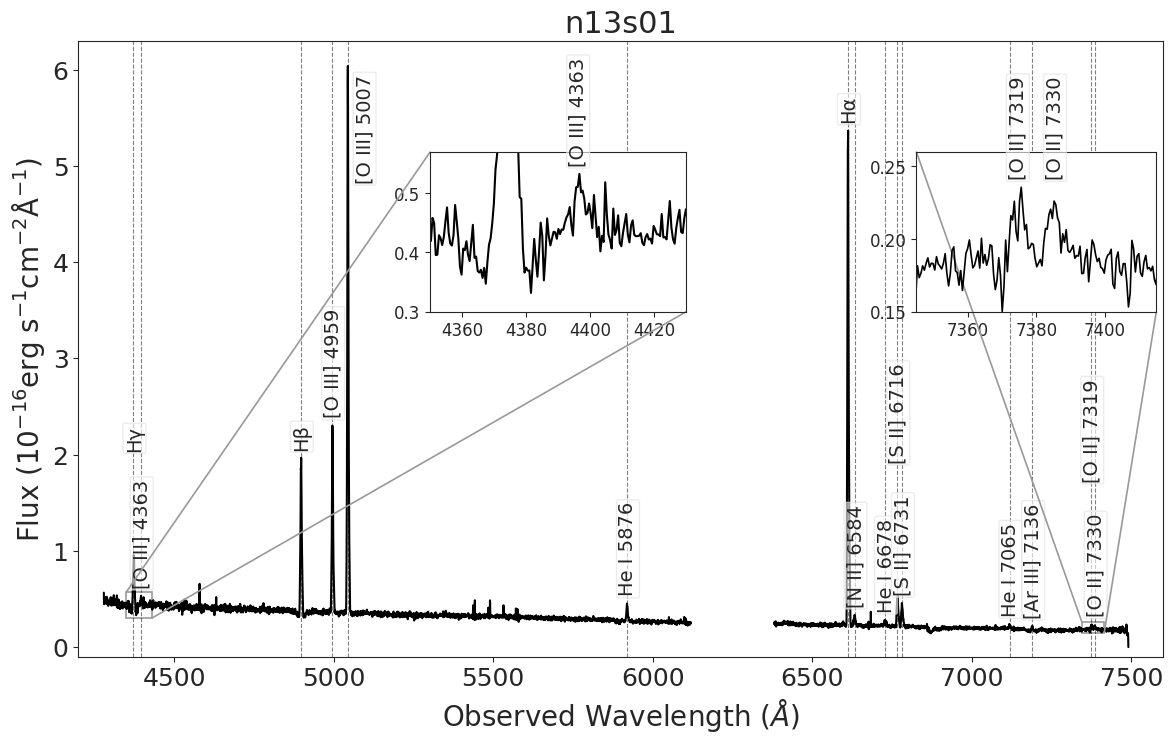

In [12]:
# Example usage
namefile1 = "n13s01_new_apOIII.txt"
z1 = 0.0075
# Define lines to displace and their factor
# Define the lines and their respective displacement factors
displace_lines1 = {
    "Hγ": 1., 
    "[O III] 5007": -1.3, 
    "[O I] 6300": 22.,
    "[S III] 6312": 10.,
    "[S II] 6716": 1.3,
    "[O II] 7319": 1.4 # Apply a displacement factor of 1.5 to the Hα line  # Apply a displacement factor of 3.0 to the OIII line
}

# Define line to displacing in x-axis
displace_lines_x1 = {
    "[O III] 5007": 50, 
    }

wavelengths1, flux1 = extract_spectrum(path, namefile1)
savefig1 = "../Spectra_txt/n13s01-spec-v3.png"
plot_spectrum(wavelengths1, flux1, emission_lines1, z=z1, xlim=(4200, 7600), ylim=(-0.1, 6.3), 
              displace_lines=displace_lines1, 
              displace_lines_x=displace_lines_x1, inset_positions= (-10, 100, 800, 500), 
              inset_xlim=(4350, 4430), inset_ylim=(0.3, 0.57), 
              inset_positions2= (460, 100, 800, 500), inset_xlim2=(7345, 7415), inset_ylim2=(0.15, 0.26), savefig=savefig1, title="n13s01")

# s27s07_new_apOIII.txt

In [9]:
emission_lines2 = {
        "Hγ": 4340.471, 
        "[O III] 4363": 4363.21,
        "Hβ": 4861.33,
        "[O III] 4959": 4958.911,
        "[O III] 5007": 5006.843,
        "He I 5876": 5875.66,    
        "Hα": 6562.82,
        "[N II] 6584": 6583.50,
        "He I 6678": 6678.16,
        "[S II] 6716": 6716.44,
        "[S II] 6731": 6730.82,
        "[Ar III] 7136": 7135.80,
        "[O II] 7319": 7319.45,
        "[O II] 7330": 7330.20,
    }

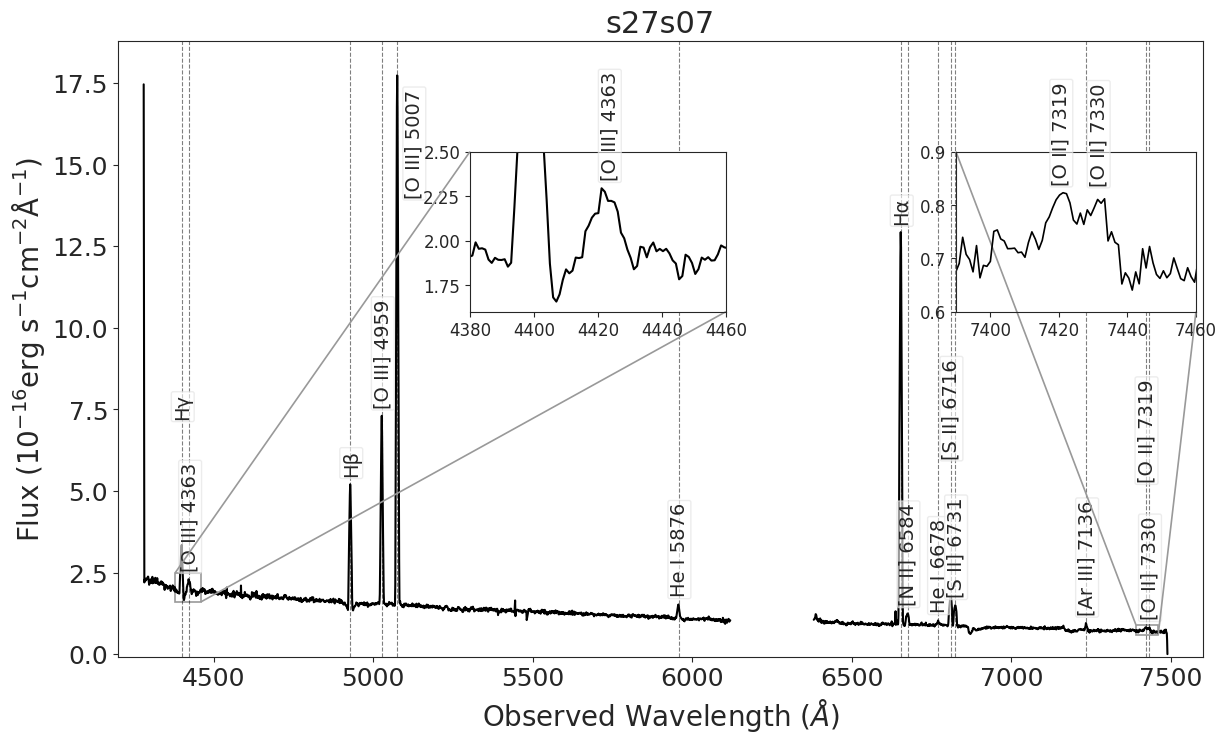

In [13]:
namefile2 = "s27s07_new_apOIII.txt"
z2 = 0.0138 
# Define lines to displace and their factor
# Define the lines and their respective displacement factors
displace_lines2 = {
    "Hγ": 3.6, 
    "[O III] 5007": -4., 
    "[S II] 6716": 4.0,
    "[O II] 7319": 4.2 # Apply a displacement factor of 1.5 to the Hα line  # Apply a displacement factor of 3.0 to the OIII line
}

# Define line to displacing in x-axis
displace_lines_x2 = {
    "[O III] 5007": 50, 
    }

wavelengths2, flux2 = extract_spectrum(path, namefile2)
savefig2 = "../Spectra_txt/s27s07-spec-v3.png"
plot_spectrum(wavelengths2, flux2, emission_lines2, z=z2, xlim=(4200, 7600), ylim=(-0.08, 18.8), 
              displace_lines=displace_lines2, 
              displace_lines_x=displace_lines_x2, inset_positions= (-10, 100, 800, 500), 
              inset_xlim=(4380, 4460), inset_ylim=(1.6, 2.5), 
              inset_positions2= (460, 100, 800, 500), inset_xlim2=(7390, 7460), inset_ylim2=(0.6, 0.9), 
              savefig=savefig2, title="s27s07")